# Imports and Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy.lib.function_base import mean
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config (display = 'diagram')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
path = 'sales_predictions.xlsx'
df = pd.read_excel(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


This information show that in the Item Fat Content column, there are 5 different value names. This will inconsistency will be fixed to show 'Low Fat' and 'Regular' names.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


# Data Cleaning

This information show that in the Item Fat Content column, there are 5 different value names. This inconsistency will be fixed to show 'Low Fat' and 'Regular' names.

In [5]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [6]:
#Find and fix any inconsistent categories of Data.
#Example: fix cat, Cat, and cats so that they are cons
#regular and low fat
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace("low fat")
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg')
df['Item_Fat_Content'].value_counts()

Low Fat    5423
Regular    3100
Name: Item_Fat_Content, dtype: int64

In [7]:
df.duplicated().sum()

0

There are two columns that have missing values. The Item Weight column is missing 1,463 values, which is 17.17% of its values. The Outlet Size column is missing 2,410 values, which is 28.27% of its values. Deleting these columns would skew the results of the preprocessing, so they will be adjusted during the pipeline phase of this analysis.

In [8]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
df.shape

(8523, 12)

The Item Identifier column was dropped. It was irrelevant to this data set and the analysis.

In [10]:
df = df.drop(columns = 'Item_Identifier')

The target for the data is the "Item Outlet Sales" column. The rest of the information will be kept in the X section of the data.

In [11]:
y = df['Item_Outlet_Sales']

In [12]:
X = df.drop(columns = 'Item_Outlet_Sales')

In [13]:
df2 = df.copy()
df2

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [14]:
# Revisiting the Project

# Imports and Libraries

In [15]:
#set text displays for sk learn
from sklearn import set_config
set_config(display = 'text')

# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Models and evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import joblib

# Setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

# Set pandas to display more columns
pd.set_option('display.max_columns', 50)

# Load and Read the Data

In [16]:
url = 'C:/Users/16024/Desktop/CLass Dojo/sales_predictions.xlsx'
df2 = pd.read_excel(url)
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
#Find and fix any inconsistent categories of Data.
#Example: fix cat, Cat, and cats so that they are cons
#regular and low fat
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace("low fat")
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace('LF')
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace('reg')
df2['Item_Fat_Content'].value_counts()

Low Fat    5423
Regular    3100
Name: Item_Fat_Content, dtype: int64

In [18]:
df2 = df2.drop(columns = 'Item_Identifier')

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                6113 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


# X and y Variables and Train_Test_Split

In [20]:
def evaluate_regression(model, X_train_df2,y_train_df2, X_test_df2, y_test_df2):
    """Evaluates a scikit learn regression model using r-squared and RMSE"""

    ## Training Data
    y_pred_train = model.predict(X_train_df2)
    r2_train = metrics.r2_score(y_train_df2, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train_df2, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test_df2)
    r2_test = metrics.r2_score(y_test_df2, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test_df2, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

# Functions Needed for this Dataset

In [21]:
+df#for plotting coeffs
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [22]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

In [23]:
## replace inconsistent categories
fat_content_map = {'LF':'Low Fat',
                   'reg':'Regular',
                   'low fat':'Low Fat'}
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace(fat_content_map)
## Verify
df2['Item_Fat_Content'].value_counts()

Low Fat    5423
Regular    3100
Name: Item_Fat_Content, dtype: int64

In [24]:
## Make x and y variables
y = df2['Item_Outlet_Sales'].copy()
X = df2.drop(columns=['Item_Outlet_Sales', 'Outlet_Identifier']).copy()

## train-test-split with random state for reproducibility
X_train_df2, X_test_df2, y_train_df2, y_test_df2 = train_test_split(X, y, random_state=42)

In [25]:
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)

# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple,
                                       remainder='passthrough',
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026B837ED220>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer

In [26]:
# transform data
# Fit the ColumnTransformer called 'preprocessor' on the training data.

#fit on train
preprocessor.fit(X_train_df2)
feature_names = preprocessor.get_feature_names_out()

# transform train and test
X_train_df2_processed = preprocessor.transform(X_train_df2)
X_test_df2_processed = preprocessor.transform(X_test_df2)

# get column names
cols = preprocessor.get_feature_names_out()

#View the transformations
X_train_df2 = pd.DataFrame(X_train_df2_processed, columns=cols)
X_test_df2 = pd.DataFrame(X_test_df2_processed, columns=cols)
X_test_df2

X_train_df2.index = y_train_df2.index
X_test_df2.index = y_test_df2.index
X_test_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2131 entries, 7503 to 1784
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      2131 non-null   float64
 1   Item_Visibility                  2131 non-null   float64
 2   Item_MRP                         2131 non-null   float64
 3   Outlet_Establishment_Year        2131 non-null   float64
 4   Item_Fat_Content_Low Fat         2131 non-null   float64
 5   Item_Fat_Content_Regular         2131 non-null   float64
 6   Item_Type_Baking Goods           2131 non-null   float64
 7   Item_Type_Breads                 2131 non-null   float64
 8   Item_Type_Breakfast              2131 non-null   float64
 9   Item_Type_Canned                 2131 non-null   float64
 10  Item_Type_Dairy                  2131 non-null   float64
 11  Item_Type_Frozen Foods           2131 non-null   float64
 12  Item_Type_Fruits 

In [27]:
y_test_df2.head()

7503    1743.0644
2957     356.8688
7031     377.5086
1084    5778.4782
856     2356.9320
Name: Item_Outlet_Sales, dtype: float64

# Model 1: Linear Regression

Fit and evalutate your Linear Regression model using your dataframe X_train and X_test data.

In [28]:
# apply linear regression and display coefficients using a pre-defined function
lin_reg= LinearRegression(fit_intercept = False)
lin_reg.fit(X_train_df2,y_train_df2)

LinearRegression(fit_intercept=False)

In [29]:
evaluate_regression(lin_reg, X_train_df2, y_train_df2,
                    X_test_df2, y_test_df2)

Training Data:	R^2= 0.56	RMSE= 1139.59
Test Data:	R^2= 0.57	RMSE= 1092.83


# Model

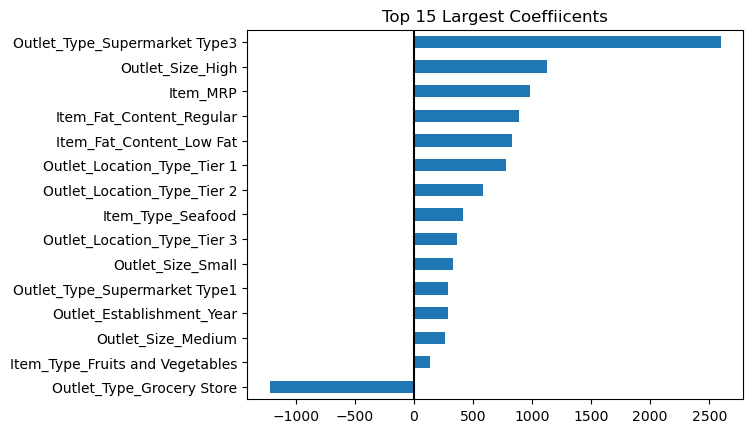

In [30]:
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_

## rank the coeffs and select the top_n
top_n = 15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()

## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');
plt.savefig('lin-reg.png')

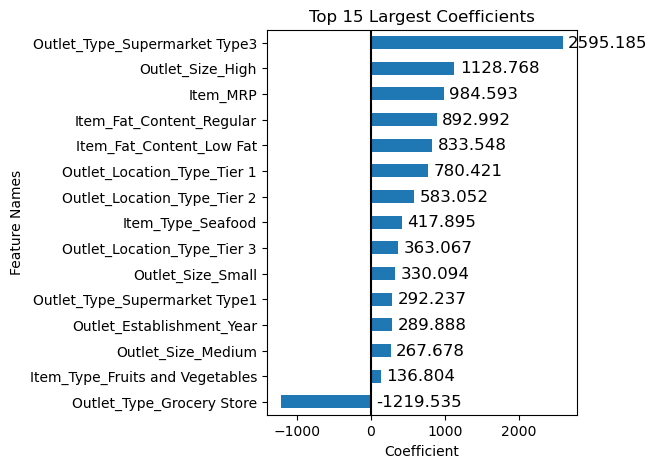

In [31]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);

# Linear Regression Model
Top 3 Most Impactful Features

Outlet_Type_Supermarket_Type3
Outlet_Size_High
Item_MRP
Interpretation of the Coefficients

The size of the outlet is important to the sales of the groceries. It increases their sales by 2,595.185.

The amount of customers is important to the sales of the groceries. It increases their sales by 1128.768.

The Item_MRP increases the sales of the groceries by 984.593.


# Model 2: Decision Tree Regression
Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.

In [32]:
# Fit and train the data.
dec_tree= DecisionTreeRegressor()
dec_tree.fit(X_train_df2,y_train_df2)

DecisionTreeRegressor()

In [33]:
evaluate_regression(dec_tree, X_train_df2, y_train_df2, X_test_df2,y_test_df2)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.20	RMSE= 1481.90


# Extract and visualize the coefficients that your model determined.

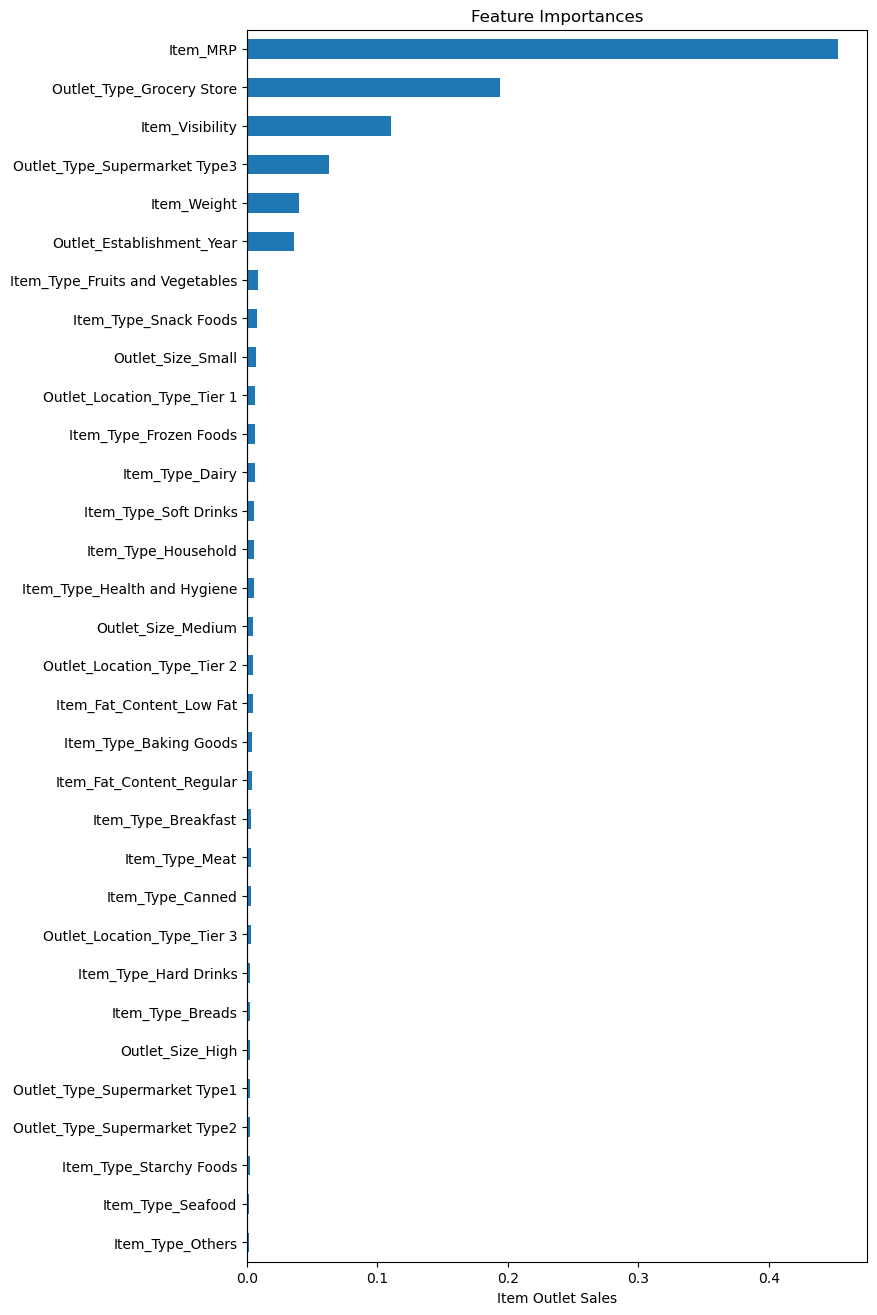

In [34]:
# Create model and save
coeffs = pd.Series(dec_tree.feature_importances_, index=feature_names,
                        name='Feature Importances')
## Plot everything but outlet identifier
ax = coeffs.sort_values().plot(kind='barh', figsize=(8,16))
ax.axvline(0, color='k')
ax.set(xlabel='Item Outlet Sales', title="Feature Importances");
plt.savefig('dec-tree.png')

# Identify the top 5 most important features.
Item_MRP

Outlet_Type_Grocery_Store

Item_Visibility

Outlet_Type_Supermartet_3

Item_Weight

# Modeling 3: Tuned Decision Tree Regression
I kept the default decision tree because I wanted to see if tuning it would give a different assessemnt of the data.

In [35]:
# What was the depth of the default tree?
dec_tree.get_depth()

40

In [36]:
# Try the loops through 2 and 40 and see which depth would give the best score
depths= list(range(2, 42))
scores = pd.DataFrame(index=depths, columns=["Test Score","Train Score"])

for depth in depths:
  dec_tree=DecisionTreeRegressor(max_depth=depth, random_state=42)
  dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
  dec_tree_pipe.fit(X_train_df2, y_train_df2)
  train_score=dec_tree_pipe.score(X_train_df2, y_train_df2)
  test_score=dec_tree_pipe.score(X_test_df2, y_test_df2)
  scores.loc[depth, "Train Score"] = train_score
  scores.loc[depth, "Test Score"] = test_score

,Test Score,Train Score
5,0.59472,0.603934
4,0.584005,0.582625
6,0.58098,0.614979
7,0.574537,0.627557
8,0.55474,0.645211


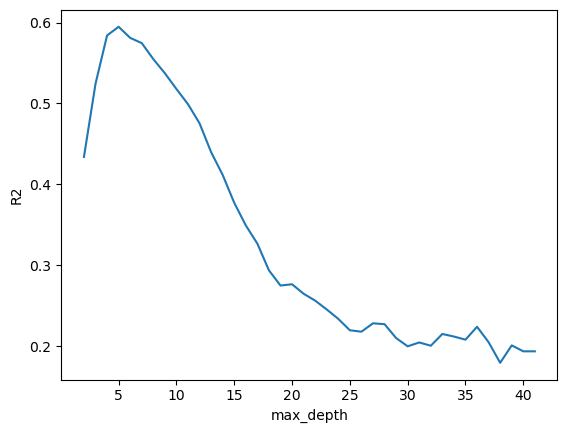

In [37]:
# Plot the model
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

# Which max_depth gives the best score?
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

# Model Interpretation
This model shows that the best depth to use is 5 because it has the highest R squared score. So, in the following analysis, the max depth that will be used is 5.

In [38]:
# Fit the data
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_df2,y_train_df2)
evaluate_regression(dec_tree_5, X_train_df2, y_train_df2, X_test_df2,y_test_df2)

Training Data:	R^2= 0.60	RMSE= 1082.65
Test Data:	R^2= 0.59	RMSE= 1057.43


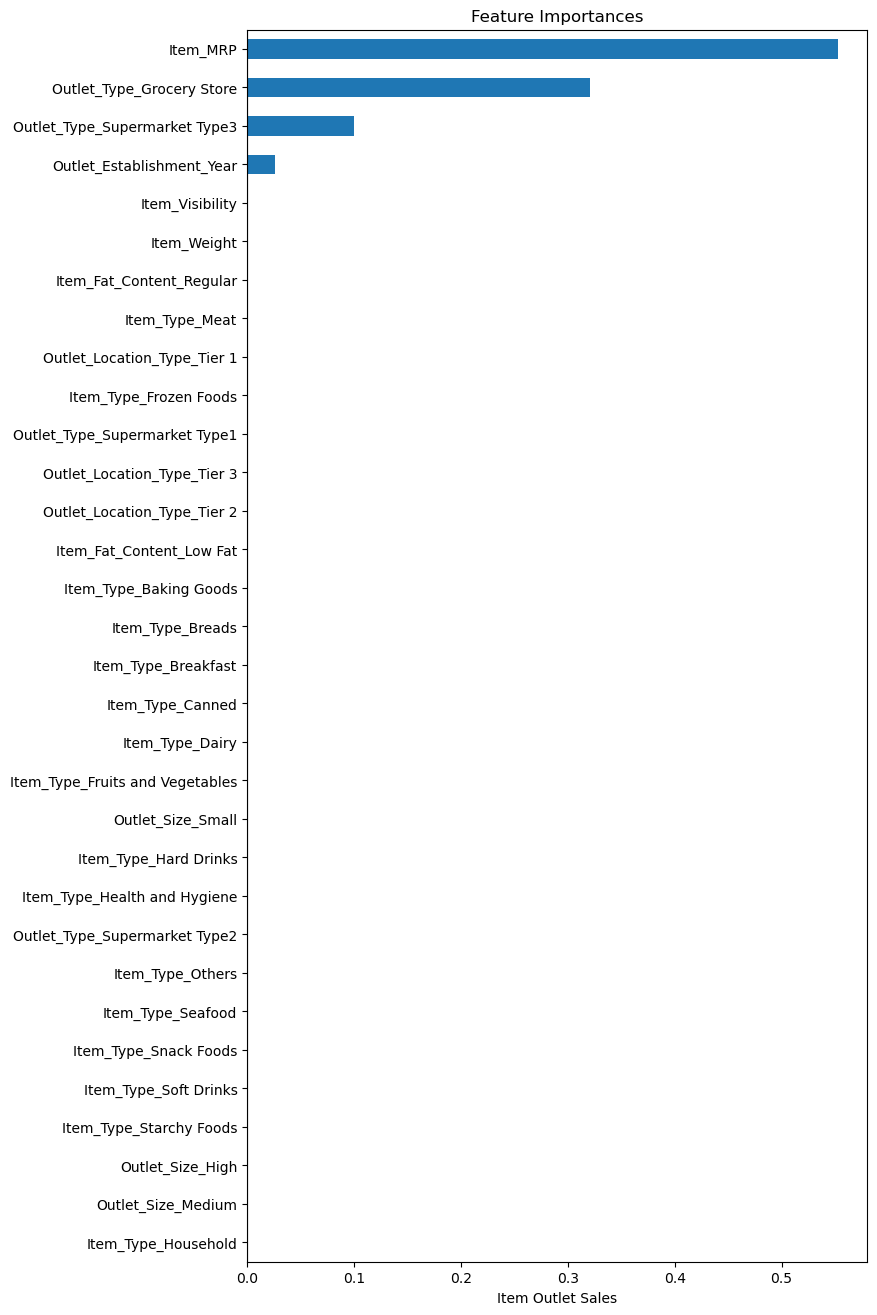

In [39]:
# Crate and plot the model
coeffs = pd.Series(dec_tree_5.feature_importances_, index=feature_names,
                        name='Feature Importances')
## Plot everything but outlet identifier
ax = coeffs.sort_values().plot(kind='barh', figsize=(8,16))
ax.axvline(0, color='k')
ax.set(xlabel='Item Outlet Sales', title="Feature Importances");
plt.savefig('tuned_dec-tree.png')

# Identify the top 5 most important features.
Item_MPR

Outlet_Type_Grocery_Store

Outlet_Type_Supermarket_Type3

Outlet Establishment_Year

Item_Visibility

# Serialize Your Best Models with Joblib

In [40]:
export = {'preprocessor': preprocessor,
          'X_train':X_train_df2,
          'y_train': y_train_df2,
          'X_test':X_test_df2,
          'y_test': y_test_df2,
          'DecisionTreeRegressor': dec_tree_5 }
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']